In [ ]:
import pandas as pd
import pyspark.sql.functions as f
from functools import reduce
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ExcelToSpark").getOrCreate()
file1_pd = pd.read_csv("fl1.csv")
file2_pd = pd.read_csv("fl2.csv")

file1_spark = spark.createDataFrame(file1_pd)
file2_spark = spark.createDataFrame(file2_pd)

### Importation done

In [3]:
file1_spark.printSchema()
file2_spark.printSchema()

root
 |-- KEY: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- TITLE_COMPL: double (nullable = true)
 |-- PROSP3_MEASURE: string (nullable = true)
 |-- FREQ: string (nullable = true)
 |-- S_NCA: string (nullable = true)
 |-- PROSP3_SECURITIES_TYPE: string (nullable = true)
 |-- MTR: string (nullable = true)
 |-- CURR_ISSNC: string (nullable = true)
 |-- PROSP3_OFFER_TYPE: string (nullable = true)
 |-- PROSP3_DOCUMENT_TYPE: string (nullable = true)
 |-- SEC_TYPE_CFI: string (nullable = true)
 |-- ISSUER_COU: string (nullable = true)
 |-- ISSUER_SECTOR: string (nullable = true)
 |-- PROSP3_PRSP_TYPE: string (nullable = true)
 |-- PROSP3_SME_CAT_TYPE: string (nullable = true)
 |-- PROSP3_PSSP: string (nullable = true)
 |-- PROSP3_VENUE: string (nullable = true)
 |-- PROSP3_LNGG: string (nullable = true)
 |-- MV: string (nullable = true)

root
 |-- GROUP: string (nullable = true)
 |-- TIME_PERIOD: string (nullable = true)
 |-- PK: double (nullable = true)
 |-- KEY: strin

In [ ]:

df_joined = file1_spark.join(file2_spark, on='KEY', how='left')
df_joined.printSchema()
df_joined.show(10)

root
 |-- KEY: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- TITLE_COMPL: double (nullable = true)
 |-- PROSP3_MEASURE: string (nullable = true)
 |-- FREQ: string (nullable = true)
 |-- S_NCA: string (nullable = true)
 |-- PROSP3_SECURITIES_TYPE: string (nullable = true)
 |-- MTR: string (nullable = true)
 |-- CURR_ISSNC: string (nullable = true)
 |-- PROSP3_OFFER_TYPE: string (nullable = true)
 |-- PROSP3_DOCUMENT_TYPE: string (nullable = true)
 |-- SEC_TYPE_CFI: string (nullable = true)
 |-- ISSUER_COU: string (nullable = true)
 |-- ISSUER_SECTOR: string (nullable = true)
 |-- PROSP3_PRSP_TYPE: string (nullable = true)
 |-- PROSP3_SME_CAT_TYPE: string (nullable = true)
 |-- PROSP3_PSSP: string (nullable = true)
 |-- PROSP3_VENUE: string (nullable = true)
 |-- PROSP3_LNGG: string (nullable = true)
 |-- MV: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- TIME_PERIOD: string (nullable = true)
 |-- PK: double (nullable = true)
 |-- OBS_VALUE: doubl

25/04/10 21:44:48 WARN TaskSetManager: Stage 1 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+-----

#### Okay here the title_compl column is filled with NaNs meaning that there was probably a Null entry that overrid the whole column. fix this.

In [ ]:
def add_outlier_thresholds(
    data,
    numbercol,
    groupbycols=None,
    showstats=False,
    use_logs=False
):
    """
    Identifies outliers in the specified column based on whether they exceed the
    median by over 3 or 4 standard deviations.
    """
    if groupbycols is None:
        groupbycols = []

    col3sd = numbercol + '_3sd'
    col4sd = numbercol + '_4sd'

    stats = (data
             .groupBy(groupbycols)
             .agg(
                 f.expr(f'percentile_approx({numbercol}, 0.5)').alias('median'),
                 f.stddev(f.col(numbercol)).alias('stddev')
             )
             .withColumn('3sd', f.col('median') + f.col('stddev')*3)
             .withColumn('4sd', f.col('median') + f.col('stddev')*4)
    )

    if groupbycols:
        data_alias = data.alias('data')
        stats_alias = stats.alias('stats')

        join_expr = reduce(
            lambda x, y: x & y,
            [f.col('data.' + c).eqNullSafe(f.col('stats.' + c))
             for c in groupbycols]
        )
        data = (data_alias
                .join(stats_alias, on=join_expr, how='left')
                .drop(*[f.col('stats.' + c) for c in groupbycols])
        )
    else:
        data = (data
                .withColumn('dummykey', f.lit(1))
                .join(
                    stats.withColumn('dummykey', f.lit(1)),
                    on='dummykey',
                    how='left'
                )
                .drop('dummykey')
        )

    if use_logs:
        data = (data
                .withColumn(
                    col3sd,
                    f.when(f.log(f.abs(f.col(numbercol))) > f.col('3sd'), True)
                     .otherwise(False)
                )
                .withColumn(
                    col4sd,
                    f.when(f.log(f.abs(f.col(numbercol))) > f.col('4sd'), True)
                     .otherwise(False)
                )
                .drop('median', 'stddev', '3sd', '4sd')
        )
    else:
        data = (data
                .withColumn(
                    col3sd,
                    f.when(f.col(numbercol) > f.col('3sd'), True).otherwise(False)
                )
                .withColumn(
                    col4sd,
                    f.when(f.col(numbercol) > f.col('4sd'), True).otherwise(False)
                )
                .drop('median', 'stddev', '3sd', '4sd')
        )

    if showstats:
        count_3sd = data.filter(f.col(col3sd) == True).count()
        count_4sd = data.filter(f.col(col4sd) == True).count()
        print(f"Number of >3sd outliers in {numbercol}: {count_3sd}")
        print(f"Number of >4sd outliers in {numbercol}: {count_4sd}")

    return data

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def melisa_outliers(
    spark_df,
    mode='thresholds',
    numbercol='OBS_VALUE',
    groupbycols=None,
    showstats=False,
    use_logs=False,
    min_filter=None,
    min_date=None,
    feature_cols=None
):

    if groupbycols is None:
        groupbycols = []

    if mode == 'random_forest_regressor':

        df_pd = spark_df.toPandas()

        if feature_cols is None:
            numeric_cols = df_pd.select_dtypes(include=[float, int]).columns
            feature_cols = [c for c in numeric_cols if c != numbercol]

        # Drop any rows missing target or features
        df_pd = df_pd.dropna(subset=[numbercol] + feature_cols)

        X = df_pd[feature_cols]
        y = df_pd[numbercol]

        rfr = RandomForestRegressor(n_estimators=50, random_state=42)
        rfr.fit(X, y)

        #pred residuals

        df_pd['pred_rfr'] = rfr.predict(X)
        df_pd['residual_rfr'] = df_pd[numbercol] - df_pd['pred_rfr']
        resid_std = df_pd['residual_rfr'].std()
        threshold_3sd = 3 * resid_std

        df_pd['rfr_outlier'] = (df_pd['residual_rfr'].abs() > threshold_3sd)

        # opt do for 4 as well
        # df_pd['rfr_outlier_4sd'] = (df_pd['residual_rfr'].abs() > threshold_4sd)

        if showstats:
            print("Random Forest Regressor-based Outliers:")
            print(df_pd['rfr_outlier'].value_counts())

        new_df = spark.createDataFrame(df_pd)
        return new_df

    elif mode == 'thresholds':
        if min_filter is not None:
            spark_df = spark_df.filter(f.col(numbercol) > min_filter)

        out_df = add_outlier_thresholds(
            data=spark_df,
            numbercol=numbercol,
            groupbycols=groupbycols,
            showstats=showstats,
            use_logs=use_logs
        )
        return out_df

    else:
        raise ValueError(f"Unknown mode: {mode}")

In [ ]:
# If you only need the data from file2_spark:
df_out = melisa_outliers(
    spark_df=df_joined,
    mode='thresholds',
    numbercol='OBS_VALUE',
    groupbycols=['TIME_PERIOD'],  # group by TIME_PERIOD
    showstats=True,
    use_logs=False
)

df_out.show(20)

25/04/10 22:18:23 WARN TaskSetManager: Stage 223 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/10 22:18:24 WARN TaskSetManager: Stage 242 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


Number of >3sd outliers in OBS_VALUE: 1785
Number of >4sd outliers in OBS_VALUE: 1473


25/04/10 22:18:24 WARN TaskSetManager: Stage 261 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/10 22:18:25 WARN TaskSetManager: Stage 263 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+----------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+---------------+------------+-------------+-------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|   ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|             PK|   OBS_VALUE|OBS_VALUE_3sd|OBS_VALUE_4sd|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+----------------+--------

###
 bcs of the null issue i just deleted it( ill fix later).

In [ ]:
df_notitle = df_joined.drop('TITLE_COMPL')

df_out2 = melisa_outliers(
    spark_df=df_notitle,
    mode='random_forest_regressor',
    numbercol='OBS_VALUE',
    groupbycols=['TIME_PERIOD'],
    showstats=True,
    use_logs=False
)

25/04/10 22:18:31 WARN TaskSetManager: Stage 279 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


Random Forest Regressor-based Outliers:
rfr_outlier
False    150825
True       1203
Name: count, dtype: int64


25/04/10 22:22:37 WARN TaskSetManager: Stage 284 contains a task of very large size (4860 KiB). The maximum recommended task size is 1000 KiB.


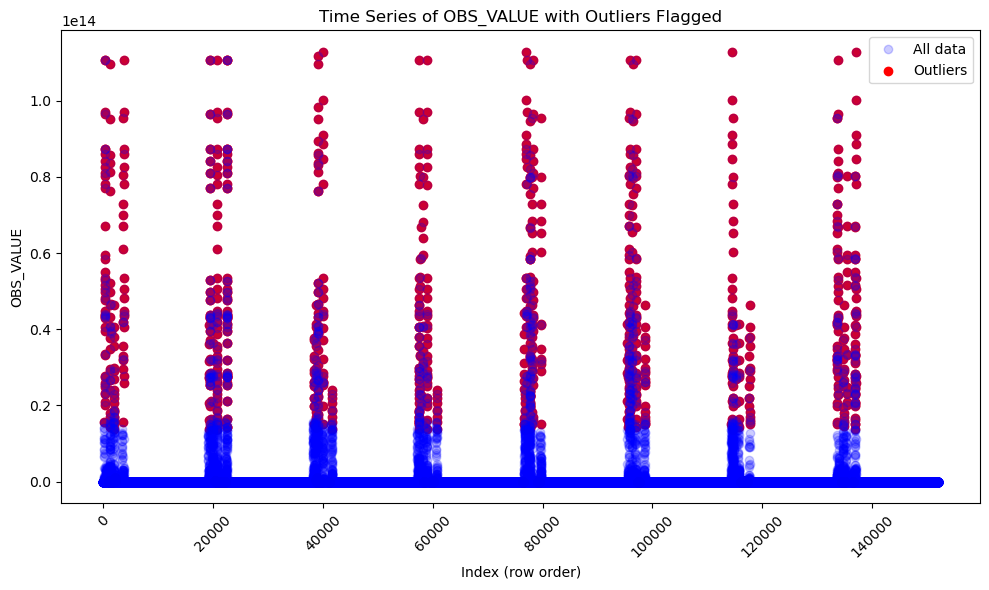

25/04/10 22:36:00 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 512609 ms exceeds timeout 120000 ms
25/04/10 22:36:00 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/10 22:36:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [35]:
import matplotlib.pyplot as plt

pdf_out = df_out2.toPandas()
#pdf_outliers = pdf_out[pdf_out['OBS_VALUE_4sd'] == True]
pdf_outliers = pdf_out[pdf_out['rfr_outlier'] == True]
plt.figure(figsize=(10, 6))

plt.plot(
    pdf_out.index,
    pdf_out['OBS_VALUE'],
    marker='o',
    linestyle='',
    color='blue',
    alpha=0.2,
    label='All data'
)

plt.scatter(
    pdf_outliers.index,
    pdf_outliers['OBS_VALUE'],
    color='red',
    label='Outliers'
)

plt.xlabel('Index (row order)')
plt.ylabel('OBS_VALUE')
plt.title('Time Series of OBS_VALUE with Outliers Flagged')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
pdf_out['OBS_VALUE_3sd'].value_counts()
pdf_out['OBS_VALUE_4sd'].value_counts()

OBS_VALUE_4sd
False    150555
True       1473
Name: count, dtype: int64